<a href="https://cocl.us/DL0320EN_TOP_IMAGE">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0320EN/Assets/Images/Top.png" width="750" alt="IBM 10TB Storage" />
</a>

<h1>Classifying European Money Denominations: Training a Pre-trained model  </h1>

<h2>Table of Contents</h2>

<p>In this lab, you will train the pre-trained models to classify the European currency. You will use the dataset object you created in the previous lab.</p>
<ul>
    <li><a href="#gen">Create Image Dataset Generator</a></li>
    <li><a href="#ques">Questions</a>
        <ol>
            <li><a href="q31">Question 3.1: Preparation</a></li>
            <li><a href="q32">Question 3.2: Train the model</a></li>
            <li><a href="q33">Question 3.3: Plot 5 Random Images with their predictions</a></li>
            <li><a href="q34">Question 3.4: Use the second model <code>VGG16</code> to do the prediction</a></li>
        </ol>
    </li>
    <li><a href="#save">Save the trained model</a></li>
</ul>

<p>Estimated Time Needed: <b>60 min</b></p>
<hr>

<h2>Preparation</h2>

<a href="https://cocl.us/DL0320EN_storage">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0320EN/Assets/Images/ObjectStorage.png" width="750" alt="cognitive class" />
</a>

Download the datasets you needed for this lab.

In [1]:
# # You can comment out this box when you already have the dataset
# # Step 1: Ctrl + A : Select all
# # Step 2: Ctrl + / : Comment out all; if everything selected has been comment out alreaday, then uncomment all

# # Download Training Dataset
# !wget --quiet -O /resources/data/train_data_keras.tar.gz https://cocl.us/DL0320EN_TRAIN_TAR_KERAS
# !tar -xzf /resources/data/train_data_keras.tar.gz -C /resources/data --exclude '.*'

# # Download Validation Dataset
# !wget --quiet -O /resources/data/validation_data_keras.tar.gz https://cocl.us/DL0320EN_VALID_TAR_KERAS
# !tar -xzf /resources/data/validation_data_keras.tar.gz -C /resources/data --exclude '.*'

import os
import subprocess

# Get the current working directory
cwd = os.getcwd()

# Define paths relative to the current working directory
data_dir = os.path.join(cwd, "resources", "data")

# URLs and file paths
train_tar_url = "https://cocl.us/DL0320EN_TRAIN_TAR_KERAS"
train_tar_path = os.path.join(data_dir, "training_data_keras.tar.gz")

valid_tar_url = "https://cocl.us/DL0320EN_VALID_TAR_KERAS"
valid_tar_path = os.path.join(data_dir, "validation_data_keras.tar.gz")

test_tar_url = "https://cocl.us/DL0320EN_TEST_TAR_KERAS"
test_tar_path = os.path.join(data_dir, "test_data_keras.tar.gz")

# Create the data directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Download and extract the training data
subprocess.run(["wget", "-q", "-O", train_tar_path, train_tar_url], check=True)
subprocess.run(
    ["tar", "-xzf", train_tar_path, "-C", data_dir, "--exclude", ".*"], check=True
)

# Download and extract the validation data
subprocess.run(["wget", "-q", "-O", valid_tar_path, valid_tar_url], check=True)
subprocess.run(
    ["tar", "-xzf", valid_tar_path, "-C", data_dir, "--exclude", ".*"], check=True
)

# Download and extract the test data
subprocess.run(["wget", "-q", "-O", test_tar_path, test_tar_url], check=True)
subprocess.run(
    ["tar", "-xzf", test_tar_path, "-C", data_dir, "--exclude", ".*"], check=True
)


CompletedProcess(args=['tar', '-xzf', '/home/julihocc/ibm/capstone/resources/data/test_data_keras.tar.gz', '-C', '/home/julihocc/ibm/capstone/resources/data', '--exclude', '.*'], returncode=0)

In [29]:
# Please install tensorflow 2.18.
%pip install tensorflow==2.18.0
%pip install --upgrade imageio
%pip install --upgrade matplotlib
%pip install --upgrade pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf

print(tf.__version__)


2025-01-12 17:22:31.916853: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-12 17:22:31.925466: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-12 17:22:31.937131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736724151.953235   48980 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736724151.957760   48980 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 17:22:31.981472: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

2.18.0


Import Keras Modules

In [4]:
# Keras Modules
from tensorflow import keras
from tensorflow.keras.layers import Dense

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

Import Non-Keras Modules 

In [5]:
# Non-Keras Modules

import os
from imageio import imread
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random

<hr>

<h2 id="gen">Create Image Dataset Generator</h2>

In this section, you will need to generate the dataset by using what you learned from the previous labs.

The following code will store the paths of the image dataset.

In [6]:
# Store image dataset in the directory

train_data_dir = "./resources/data/train_data_keras"
validation_data_dir = "./resources/data/validation_data_keras"
classes = ["5", "10", "20", "50", "100", "200", "500"]

Using <code>ImageDataGenerator().flow_from_directory()</code> to load the image from directory and generate the training dataset.

In [7]:
# Create the ImageDataGenerator for training dataset

train_generator = ImageDataGenerator().flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=10,
    classes=classes,
    seed=0,
    shuffle=True,
)

Found 70 images belonging to 7 classes.


Using <code>ImageDataGenerator().flow_from_directory()</code> to load the image from directory and generate the validation dataset.

In [8]:
# Create the ImageDataGenerator for validation dataset

valid_generator = ImageDataGenerator().flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=5,
    classes=classes,
    seed=0,
    shuffle=True,
)

Found 70 images belonging to 7 classes.


<hr>

<h2 id="ques">Questions</h2>

<h3 id="q31">Question 3.1: Preparation</h3><b>5 point</b>

<b>Step 1</b>: Load the pre-trained model <b>ResNet50</b>. Set <code>weights='imagenet'</code>

In [9]:
# Step 1: Load the pre-trained model ResNet50

base = ResNet50(weights="imagenet")

2025-01-12 17:22:35.864514: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


<b>Step 2:</b> The following lines of code sets the attribute <code>trainable</code> to <code>False</code>. As a result, the parameters in these layers will not be affected by training.

In [10]:
# Step2: Set parameters in pre-train model to False

for layer in base.layers:
    layer.trainable = False

<b>Step 3</b>: <b>ResNet50</b> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs. However, you are going to classify 7 different classes, so you need to remove the last layer and replace with the new classification layer.

In [11]:
# Step 3: Replace the old classification layer with the new classification layer

sec_last_base = base.layers[-2].output
connected_model = Dense(len(classes), activation="softmax")(sec_last_base)
base_input = base.input
model = Model(inputs=base_input, outputs=connected_model)

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>

In [12]:
# Print the model (PLEASE DO NOT MODIFY THIS BOX)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

<h3 id="q32">Question 3.2: Train the model</h3><b>5 points</b>

<b>Step 1</b>: Use the <code>model.compile()</code> to set the configuration for the model. Use the optimizer <b>Adam</b>, loss function <b>categorical_crossentropy</b> and <code>metrics = ['accuracy']</code> as the parameters for training the model.

In [13]:
# Step 1: Use model.compile() to set the configuration

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

<b>Step 2: </b>Train the model with 20 epochs.

In [ ]:
# Step 2: Train the model

N_EPOCHES = 20

STEPS = train_generator.n // train_generator.batch_size

model.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=STEPS,
    epochs=N_EPOCHES,
)

Epoch 1/20


/home/julihocc/ibm/capstone/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.1321 - loss: 2.5792 - val_accuracy: 0.3714 - val_loss: 1.6069
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 782ms/step - accuracy: 0.6030 - loss: 1.3102 - val_accuracy: 0.7571 - val_loss: 0.9029
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 831ms/step - accuracy: 0.9360 - loss: 0.5431 - val_accuracy: 0.9571 - val_loss: 0.5287
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 888ms/step - accuracy: 1.0000 - loss: 0.3218 - val_accuracy: 1.0000 - val_loss: 0.3333
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 1.0000 - loss: 0.1309 - val_accuracy: 1.0000 - val_loss: 0.2350
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 980ms/step - accuracy: 1.0000 - loss: 0.1194 - val_accuracy: 1.0000 - val_loss: 0.1852
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 1.0000 - loss: 0.0804 - val_accuracy: 1.0000 - val_loss: 0.1503
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 873ms/step - accuracy: 1.0000 - loss: 0.0587 - val_accuracy: 1.0000 - val_loss: 0.1271
Epoch 9/20


The information of loss and accuarcy for both training and validation is in <code>model.history.history</code>. Get the training history, and store the history into <code>train_history</code>.

In [15]:
# Get the training history

train_history = model.history.history

for key in train_history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


<b>Step 3</b>: Plot out the result of loss for both training and validation.<br> <b>(Your peer reviewer is going to mark based on what you plot here.)</b>

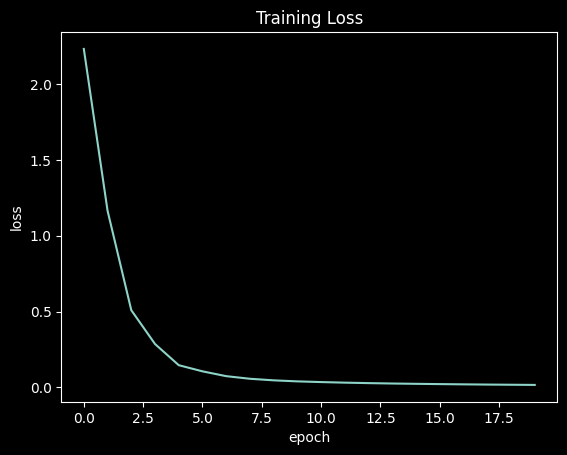

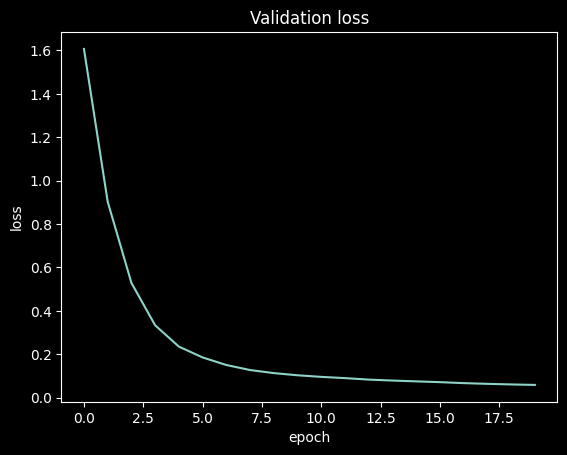

In [16]:
# Step 3: Plot the loss for both training and validation
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.plot(train_history["loss"])
plt.show()

plt.title("Validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.plot(train_history["val_loss"])
plt.show()


<b>Step 4</b>: Plot out the result of accuracy for both training and validation.<br> <b>(Your peer reviewer is going to mark based on what you plot here.)</b>

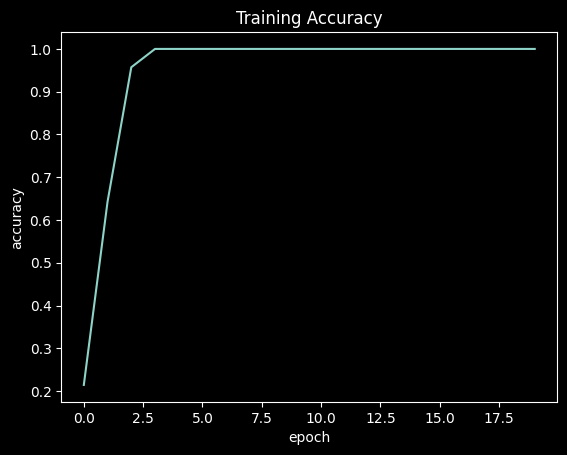

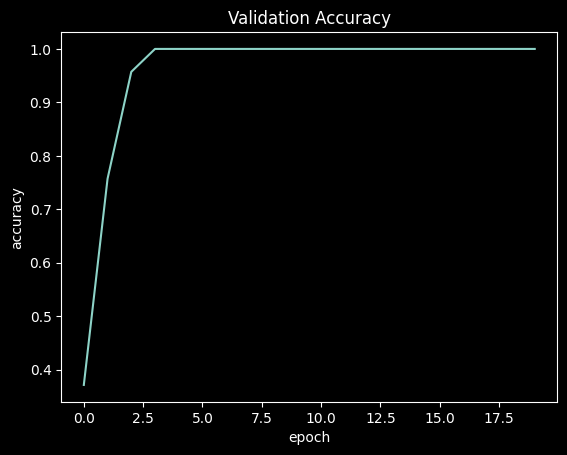

In [17]:
# Step 4: Plot the accuracy for both training and validation
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.plot(train_history["accuracy"])
plt.show()

plt.title("Validation Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.plot(train_history["val_accuracy"])
plt.show()


<h3 id="q33">Question 3.3: Plot 5 Random Images with their predictions</h3><b>3 points</b>

Use the <b>validation_dataset</b> to see whether model can predict. (You will use the <b>test_dataset</b> in the future lab. Use the <b>validation_dataset</b> for now.) Notice that you need to set the <code>shuffle</code> to <code>False</code>, so the the order of predictions will be the same as the file loading order.

In [18]:
# Generate test dataset and generate the prediction results

test_valid_generator = ImageDataGenerator().flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=5,
    classes=classes,
    seed=0,
    shuffle=False,
)

Found 70 images belonging to 7 classes.


Create a test dataset using validation data. Plot 5 random images which index is in the <code>numbers</code> list. Also print the predicted label and print a string indicate whether it has been correctly classified or mis-classified.<br> <b>(Your peer reviewer is going to mark based on what you plot here.)</b>
<p>Steps:</p>
<ol>
    <li>Use <code>MODEL.predict_generator()</code> to do the prediction</li>
    <li>Use <code>np.argmax()</code> to find the location of the maximum value</li>
    <li>Get the class labels from <code>train_generator</code> using <code>train_generator.filenames</code></li>
    <li>Get the class indices from the previous step using <code>train_generator.class_indices</code></li>
    <li>Match classes with labels like <code>[0, 1, 2, 3, 4, 5, 6] -> ['5', '10', '20', '50', '100', '200', '500']</code></li>
    <li>Get the true label by analysis folder name on the image resource path. Notice the <code>test_valid_genertor.filename</code> order is the same as the predicted order as you did not shuffle the dataset.</li>
    <li>Compare, plot and print the result</li>
</ol>

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step


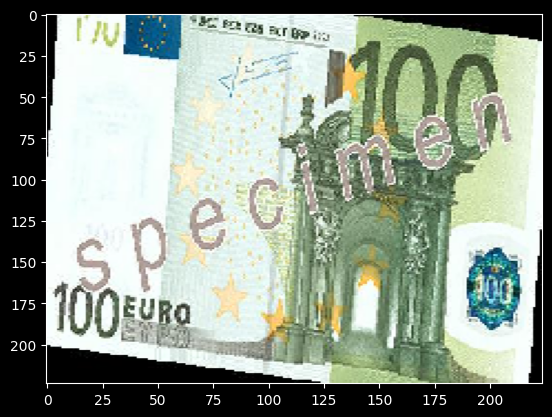

predicted: 100 (Correctly classified)


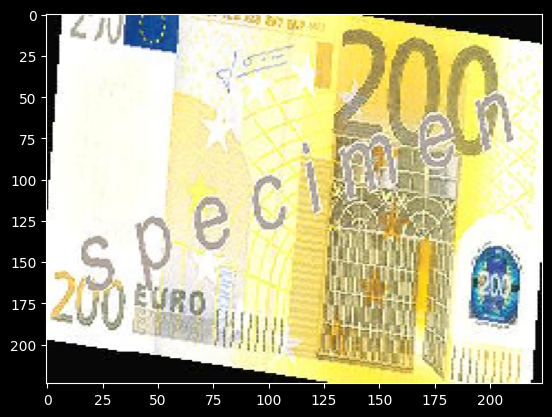

predicted: 200 (Correctly classified)


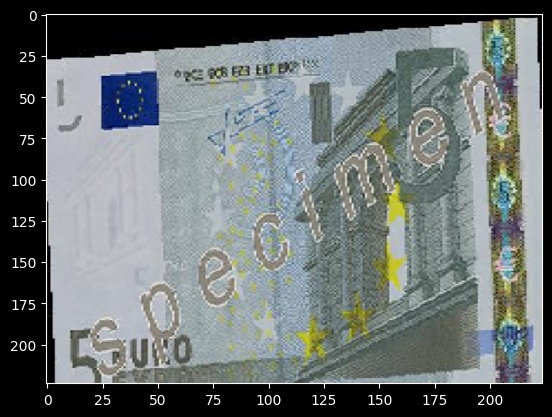

predicted: 5 (Correctly classified)


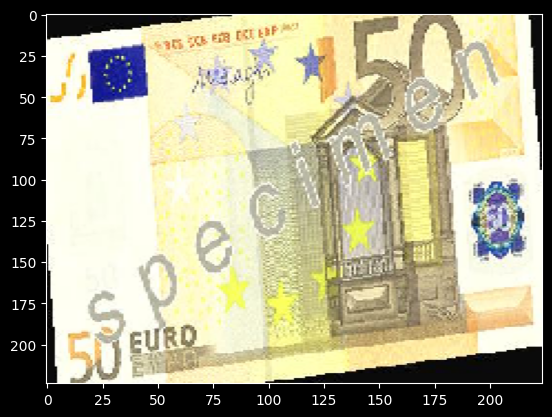

predicted: 50 (Correctly classified)


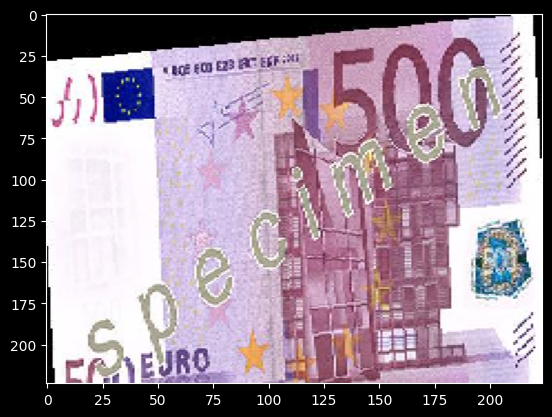

predicted: 500 (Correctly classified)


In [19]:
# Plot five random images and their predictions

random.seed(0)
numbers = [random.randint(0, 69) for i in range(0, 5)]

# Type your code here
pred = np.argmax(model.predict(test_valid_generator, 14)[numbers], axis=1)

class_labels = train_generator.class_indices
pred_labels = [
    list(class_labels.keys())[list(class_labels.values()).index(i)] for i in pred
]
true_labels = [test_valid_generator.filenames[i].split("/")[0] for i in numbers]

ndx = 0
for i in numbers:
    result_string = "predicted: {}".format(pred_labels[ndx])
    if pred_labels[ndx] == true_labels[ndx]:
        result_string += " (Correctly classified)"
    else:
        result_string += " (Incorrectly classified)"
    plt.imshow(test_valid_generator[i // 5][0][i % 5].astype(np.uint8), aspect="auto")
    plt.show()
    print(result_string)
    ndx += 1

<h3 id="q34">Question 3.4: Use the second model <code>VGG16</code> to do the prediction</h3><b>5 points</b>

Repeat the steps in Question 3.1, 3.2 to predict the result using <code>VGG16</code> model. Then, print out the last validation accuracy.

<p>Steps:</p>
<ol>
    <li>Load the pre-trained model VGG16</li>
    <li>Replace the last classification layer with only 7 classes</li>
    <li>Set the configuration (parameters) using <code>MODEL.compile()</code></li>
    <li>Train the model</li>
    <li>Print the last validation accuracy</li>
</ol>

Hint:
<ol>
    <li>Use optimizer <code>Adam</code></li>
    <li>Use loss function <code>categorical_crossentropy</code></li>
    <li>Epoches = 5</li>
</ol>

You are welcome to try any pattern of setting and find out the best result. Please name the model variable as <code>model_vgg</code>.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>

In [20]:
# Use VGG16 to train the model and print out the last validation accuracy.

vgg = VGG16(weights="imagenet")

for layer in vgg.layers:
    layer.trainable = False


2025-01-12 17:24:51.834653: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-01-12 17:24:51.955843: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


2025-01-12 17:24:52.558486: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-01-12 17:24:54.844148: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


In [21]:
sec_last_vgg = vgg.layers[-2].output
connected_vgg = Dense(len(classes), activation="softmax")(sec_last_vgg)
vgg_input = vgg.input
model_vgg = Model(inputs=vgg_input, outputs=connected_vgg)
model_vgg.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │        28,679 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,289,223 (512.27 MB)

 Trainable params: 28,679 (112.03 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [22]:
model_vgg.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [23]:
model_vgg.fit(
    train_generator,
    steps_per_epoch=STEPS,
    epochs=5,
    validation_data=valid_generator,
)

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.2704 - loss: 2.2534 - val_accuracy: 0.7429 - val_loss: 0.7011
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8945 - loss: 0.3524 - val_accuracy: 0.9857 - val_loss: 0.0937
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 1.0000 - loss: 0.0359 - val_accuracy: 1.0000 - val_loss: 0.0691
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 1.0000 - loss: 0.0173 - val_accuracy: 0.9857 - val_loss: 0.0381
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.9857 - val_loss: 0.0343


In [24]:
train_history_vgg = model_vgg.history.history

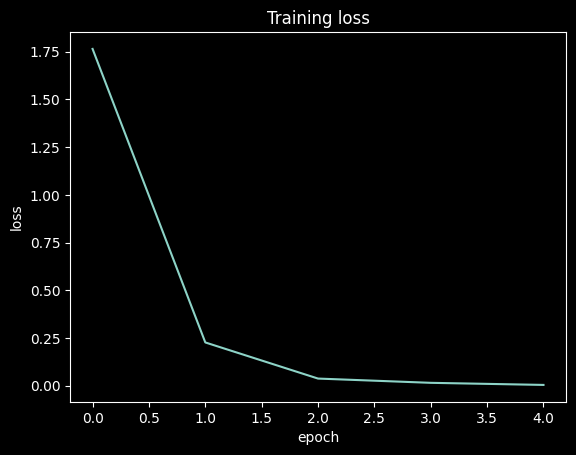

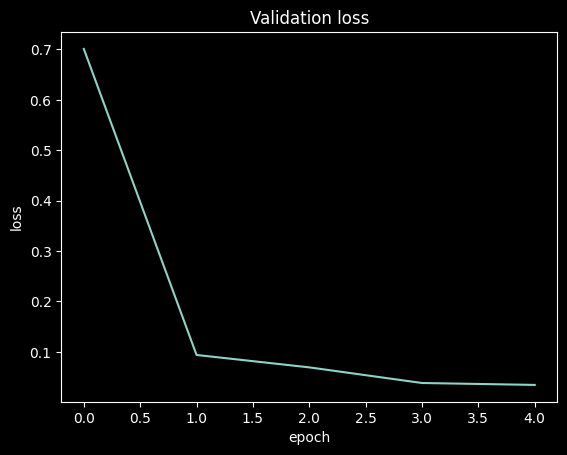

In [25]:
plt.title("Training loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.plot(train_history_vgg["loss"])
plt.show()

plt.title("Validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.plot(train_history_vgg["val_loss"])
plt.show()

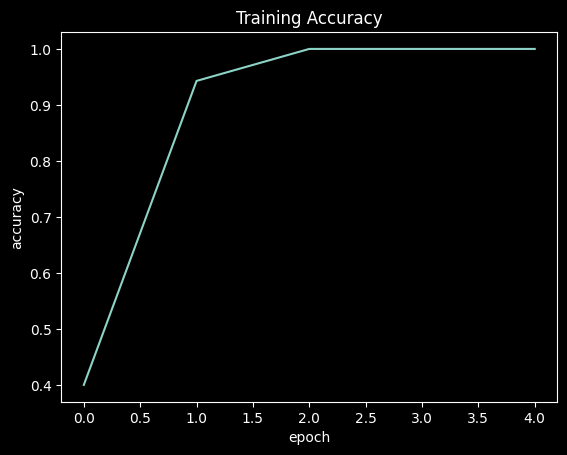

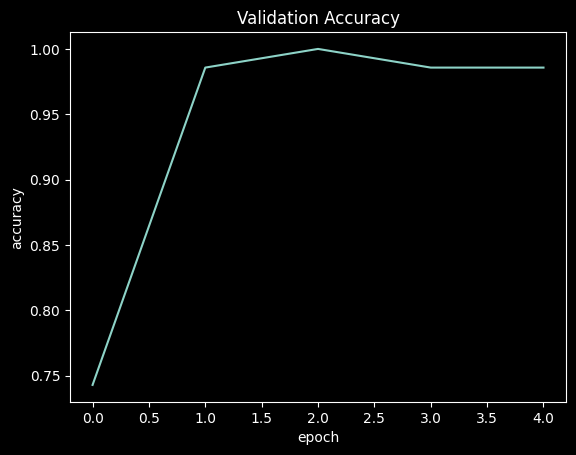

In [26]:
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.plot(train_history_vgg["accuracy"])
plt.show()

plt.title("Validation Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.plot(train_history_vgg["val_accuracy"])
plt.show()

In [27]:
print("The last Validation Accuracy is : 0.9714 ")

The last Validation Accuracy is : 0.9714 


<h2 id="#save">Save the trained model</h2>

Save the trained model for the following chapters

In [28]:
# Save the model

model.save("resnet50_keras.keras")
model_vgg.save("vgg16_keras.keras")

<a href="https://cocl.us/DLO0320EN_notebook_bott">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0320EN/Assets/Images/Bottom.png" width="750" alt="cognitive class" />
</a>

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>, <a href="https://www.linkedin.com/in/yi-leng-yao-84451275/">Yi Leng Yao</a>

<hr>

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.